# ***תרגיל 4   של הפרוייקט***

# ***חלק א***

***Cell 1: Load data and basic inspection***




---



In [15]:
import pandas as pd

# Load the filtered dataset from disk (Colab path)
filtered_df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions to avoid biasing the model with repeated texts
filtered_df = filtered_df.drop_duplicates(subset=["question"], keep="first")

# Sanity check: show columns and first rows to verify the structure
print("Columns in DataFrame:")
print(filtered_df.columns)

print("\nFirst 5 rows:")
print(filtered_df.head())

# Show global label distribution for 'level' (if exists), to understand dataset balance
if "level" in filtered_df.columns:
    print("\nGlobal distribution of 'level':")
    print(filtered_df["level"].value_counts(normalize=True))
else:
    print("\nColumn 'level' not found in DataFrame.")


Columns in DataFrame:
Index(['question', 'level'], dtype='object')

First 5 rows:
                                            question   level
0  Which magazine was started first Arthur's Maga...  medium
1  The Oberoi family is part of a hotel company t...  medium
2  Musician and satirist Allie Goertz wrote a son...    hard
3    What nationality was James Henry Miller's wife?  medium
4  Cadmium Chloride is slightly soluble in this c...  medium

Global distribution of 'level':
level
medium    0.628149
easy      0.198688
hard      0.173162
Name: proportion, dtype: float64


***Cell 2: Text preprocessing (tokenization + lemmatization)***

In [16]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

# Download required NLTK resources (run once per runtime)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()
eng_stops = set(stopwords.words("english"))

# Normalize all forms of the verb "to be" into a single token "be"
BE_FORMS = {"am", "is", "are", "was", "were", "be", "been", "being"}


def get_wordnet_pos(tag: str):
    """
    Map POS tag from nltk.pos_tag to a WordNet POS tag.
    This helps the lemmatizer pick the correct base form.
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN


# Regex patterns for cleaning
# Remove URLs, emails, @handles, #hashtags
url_email_handle_re = re.compile(r"(https?://\S+|www\.\S+|\S+@\S+|[@#]\w+)", re.IGNORECASE)

# Detect any digit inside a token
digits_re = re.compile(r"\d")

# For NON-numeric tokens: remove everything except [a-z] and spaces
non_letter_re = re.compile(r"[^a-z ]+")


def process_text_value(text: str) -> str:
    """
    Full preprocessing for a single text value:
    - Remove URLs, emails, and @handles/#hashtags
    - Tokenize
    - POS tagging
    - Lemmatization with POS
    - Normalize all 'be' verb forms to 'be'
    - Any token that contains at least one digit -> '_number' (entire token)
    - For other tokens: strip punctuation/non-letters, keep only [a-z] and spaces
    - Finally, any token that still contains the substring 'number' is collapsed to '_number'
    - (Optional) Remove stopwords [currently commented out]
    - Lowercase
    Returns a cleaned string with space-separated tokens.
    """
    # Safely handle missing or non-string values
    if not isinstance(text, str):
        return ""

    # Remove URLs, emails, handles, hashtags
    t = url_email_handle_re.sub(" ", text)

    # Tokenize and POS-tag on original (cleaned) text
    tokens = word_tokenize(t)
    tagged = pos_tag(tokens)

    lemmas = []
    for tok, pos in tagged:
        # Normalize 'be' forms early to reduce sparsity
        if tok.lower() in BE_FORMS:
            lemmas.append("be")
            continue

        # Map POS tag to WordNet POS tag and lemmatize
        wn_pos = get_wordnet_pos(pos)
        lemma = lemmatizer.lemmatize(tok, wn_pos)
        lemmas.append(lemma)

    # Lowercase all tokens
    lemmas = [w.lower() for w in lemmas]

    intermediate = []
    for w in lemmas:
        # If the token contains ANY digit, replace the entire token with '_number'
        if digits_re.search(w):
            intermediate.append("_number")
            continue

        # For non-numeric tokens: remove punctuation and non-letters
        w2 = non_letter_re.sub(" ", w).strip()
        if not w2:
            # Skip tokens that became empty after cleaning
            continue

        # If cleaning produced multiple parts (e.g. "word-word" -> "word word")
        for part in w2.split():
            if not part:
                continue
            intermediate.append(part)

    # Final pass: collapse any token that still contains 'number' into '_number'
    # This guarantees we do not get '_numbera', '_numberkm', etc.
    clean_lemmas = []
    for w in intermediate:
        if "number" in w:
            clean_lemmas.append("_number")
        else:
            clean_lemmas.append(w)

    clean_lemmas = [w for w in clean_lemmas if w not in eng_stops]

    # Join tokens back into a single cleaned string
    return " ".join(clean_lemmas)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***Cell 3: Apply preprocessing to all questions***

In [17]:
# Ensure the 'question' column exists before applying preprocessing
if "question" not in filtered_df.columns:
    raise KeyError("The DataFrame does not contain a 'question' column.")

# Apply the preprocessing function to every question in the dataset
# This creates a new column 'question_clean' that contains the normalized text
filtered_df["clean_text"] = filtered_df["question"].apply(process_text_value)

# Inspect a few examples to verify that preprocessing works as expected
print("Original vs. cleaned examples:\n")
for i in range(5):
    print(f"--- Example {i+1} ---")
    print("Original :", filtered_df.loc[filtered_df.index[i], "question"])
    print("Cleaned  :", filtered_df.loc[filtered_df.index[i], "clean_text"])
    print()


Original vs. cleaned examples:

--- Example 1 ---
Original : Which magazine was started first Arthur's Magazine or First for Women?
Cleaned  : magazine start first arthur magazine first women

--- Example 2 ---
Original : The Oberoi family is part of a hotel company that has a head office in what city?
Cleaned  : oberoi family part hotel company head office city

--- Example 3 ---
Original : Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?
Cleaned  : musician satirist allie goertz write song simpsons character milhouse matt groening name

--- Example 4 ---
Original :  What nationality was James Henry Miller's wife?
Cleaned  : nationality james henry miller wife

--- Example 5 ---
Original : Cadmium Chloride is slightly soluble in this chemical, it is also called what?
Cleaned  : cadmium chloride slightly soluble chemical also call



***Cell 4: TF-IDF vectorization of the preprocessed questions***

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Safety check: make sure 'clean_text' exists
if "clean_text" not in filtered_df.columns:
    raise KeyError("The DataFrame does not contain a 'clean_text' column. "
                   "Run the preprocessing cell first.")

# Define a TF-IDF vectorizer
# max_features limits vocabulary size to the most frequent terms
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,   # limit vocabulary size (you can tune this later)
    ngram_range=(1, 1),   # unigrams only
)

# Fit TF-IDF on the entire cleaned corpus and transform it to a sparse matrix
# Each row = one question, each column = one term from the vocabulary
X_tfidf = tfidf_vectorizer.fit_transform(filtered_df["clean_text"])

print("TF-IDF matrix shape (n_samples, n_features):", X_tfidf.shape)
print("(Num of documents, max_features)")

# Optional: extract labels if you need them later for supervised models / evaluation
if "level" in filtered_df.columns:
    y = filtered_df["level"].values
    print("Labels vector shape:", y.shape)
else:
    y = None
    print("No 'level' column found. y is set to None.")

# Show a small sample of feature names for sanity check
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nVocabulary size (len(feature_names)):", len(feature_names))
print("First 30 features:\n", feature_names[:60])


TF-IDF matrix shape (n_samples, n_features): (90418, 10000)
(Num of documents, max_features)
Labels vector shape: (90418,)

Vocabulary size (len(feature_names)): 10000
First 30 features:
 ['_number' 'aaa' 'aaron' 'ab' 'abandon' 'abba' 'abbey' 'abbot' 'abbott'
 'abbreviate' 'abbreviation' 'abby' 'abc' 'abdication' 'abduct' 'abdul'
 'abe' 'abel' 'aberdeen' 'aberdeenshire' 'abigail' 'ability' 'able'
 'aboard' 'abolish' 'abolitionist' 'aboriginal' 'abraham' 'abrams'
 'absence' 'absent' 'absolute' 'absorb' 'abstract' 'abu' 'abuse' 'ac'
 'academic' 'academy' 'accept' 'access' 'accessible' 'accessory'
 'accident' 'accidental' 'acclaim' 'acclaimed' 'accompany' 'accomplished'
 'accomplishment' 'accord' 'according' 'account' 'accountant' 'accra'
 'accredit' 'accuse' 'ace' 'achebe' 'achieve']


***Cell 5: Run K-Means for different K values***

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Choose several K values
k_values = [] #2, 15 3 ,7
# k_values = [2]
inertia_scores = []
silhouette_scores = []

print("Running K-Means on TF-IDF matrix... (may take a bit)")

for k in k_values:
    print(f"\n--- K = {k} ---")

    # KMeans (using smart initialization k-means++)
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        max_iter=300,
        random_state=42,
        n_init=10
    )

    # Fit on full TF-IDF matrix
    kmeans.fit(X_tfidf)

    # Inertia (Elbow)
    inertia = kmeans.inertia_
    inertia_scores.append(inertia)

    # Silhouette score (requires >1 cluster)
    sil_score = silhouette_score(X_tfidf, kmeans.labels_, metric='euclidean')
    silhouette_scores.append(sil_score)

    print(f"Inertia: {inertia}")
    print(f"Silhouette Score: {sil_score}")


Running K-Means on TF-IDF matrix... (may take a bit)


**Cell 6: Dimensionality reduction for clustering (TruncatedSVD)**

In [20]:
from sklearn.decomposition import TruncatedSVD

# We reduce dimensionality because TF-IDF has many features and is sparse.
# TruncatedSVD is PCA-like but works directly on sparse matrices.
svd = TruncatedSVD(
    n_components=50,   # number of latent dimensions (you can tune this)
    random_state=42
)

# Fit SVD on the TF-IDF matrix and transform it to a dense lower-dimensional space
X_svd = svd.fit_transform(X_tfidf)

print("Original TF-IDF shape :", X_tfidf.shape)
print("Reduced SVD shape     :", X_svd.shape)

# Sum of explained variance ratio gives an idea how much information we kept
explained = svd.explained_variance_ratio_.sum()
print(f"Total explained variance (approx): {explained:.3f}")


Original TF-IDF shape : (90418, 10000)
Reduced SVD shape     : (90418, 50)
Total explained variance (approx): 0.129


***Cell 7: DBSCAN clustering on reduced space and comparison***

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# הגדרת גודל המדגם
SAMPLE_SIZE = 20000

print(f"Original dataset size: {X_svd.shape[0]}")

# 1. דגימה (אם צריך)
if X_svd.shape[0] > SAMPLE_SIZE:
    print(f"Dataset is too large. Sampling {SAMPLE_SIZE} random points...")
    np.random.seed(42)
    indices = np.random.choice(X_svd.shape[0], SAMPLE_SIZE, replace=False)
    X_subset = X_svd[indices]
    df_subset = filtered_df.iloc[indices].copy()
else:
    X_subset = X_svd
    df_subset = filtered_df.copy()

print(f"Running DBSCAN on {X_subset.shape[0]} samples...")

# 2. הרצת DBSCAN
# הערה: אם את מקבלת רק אשכול אחד, כדאי לנסות לשנות את eps (למשל ל-0.3 או 0.7)
dbscan = DBSCAN(eps=0.12, min_samples=5, metric='euclidean', n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_subset)
print("DBSCAN finished!")

# 3. שמירת תוצאות
df_subset['dbscan_cluster'] = dbscan_labels

# 4. ניתוח בסיסי
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print("\nCluster counts (Label -1 represents 'Noise'):")
print(dict(zip(unique_labels, counts)))

# 5. חישוב Silhouette Score (בטוח)
# בדיקה כמה אשכולות יש שאינם רעש
n_clusters_real = len(set(dbscan_labels) - {-1})

if n_clusters_real >= 2:
    non_noise_mask = dbscan_labels != -1
    sil = silhouette_score(X_subset[non_noise_mask], dbscan_labels[non_noise_mask])
    print(f"\nDBSCAN Silhouette Score (excluding noise): {sil:.4f}")
else:
    print(f"\nCould not calculate Silhouette Score: Found {n_clusters_real} real clusters.")
    print("Silhouette Score requires at least 2 distinct clusters.")
    print("Try adjusting 'eps' (lower it to split clusters) or 'min_samples'.")

Original dataset size: 90418
Dataset is too large. Sampling 20000 random points...
Running DBSCAN on 20000 samples...
DBSCAN finished!

Cluster counts (Label -1 represents 'Noise'):
{np.int64(-1): np.int64(9883), np.int64(0): np.int64(8201), np.int64(1): np.int64(10), np.int64(2): np.int64(37), np.int64(3): np.int64(16), np.int64(4): np.int64(7), np.int64(5): np.int64(12), np.int64(6): np.int64(10), np.int64(7): np.int64(127), np.int64(8): np.int64(18), np.int64(9): np.int64(36), np.int64(10): np.int64(9), np.int64(11): np.int64(102), np.int64(12): np.int64(5), np.int64(13): np.int64(111), np.int64(14): np.int64(10), np.int64(15): np.int64(7), np.int64(16): np.int64(18), np.int64(17): np.int64(37), np.int64(18): np.int64(6), np.int64(19): np.int64(12), np.int64(20): np.int64(9), np.int64(21): np.int64(21), np.int64(22): np.int64(9), np.int64(23): np.int64(10), np.int64(24): np.int64(10), np.int64(25): np.int64(12), np.int64(26): np.int64(11), np.int64(27): np.int64(17), np.int64(28): n

***Cell 8: Analyze DBSCAN Clusters (Top Keywords & Sample Questions)***

In [32]:
# === Cell 8: Semantic Analysis for DBSCAN Sample ===

import pandas as pd
import numpy as np

print("Analyzing DBSCAN Clusters (on Sample)...")

# 1. וידוא שמשתני המדגם קיימים
if 'df_subset' not in locals() or 'indices' not in locals():
    # אם לא נעשתה דגימה (כי הדאטה היה קטן), נשתמש במקוריים
    df_subset = filtered_df
    indices = np.arange(X_tfidf.shape[0])

# 2. הוספת התוויות לדאטה-פריים של המדגם (ולא למקורי!)
df_subset['dbscan_cluster'] = dbscan_labels

# 3. יצירת מטריצת TF-IDF שמתאימה רק לשורות שבמדגם
# זה קריטי כדי שנוכל למצוא את המילים הנכונות
X_tfidf_subset = X_tfidf[indices]

unique_labels = np.unique(dbscan_labels)
feature_names = tfidf_vectorizer.get_feature_names_out()

# פונקציה מותאמת למדגם
def get_top_keywords_for_subset(cluster_mask, tfidf_sub, features, n_top=10):
    # חישוב ממוצע ה-TF-IDF עבור כל המילים באשכול הזה
    # cluster_mask הוא בוליאני (True/False) ביחס למדגם
    cluster_mean = np.array(tfidf_sub[cluster_mask].mean(axis=0)).flatten()
    sorted_indices = cluster_mean.argsort()[::-1][:n_top]
    return [features[i] for i in sorted_indices]

# מעבר על כל אשכול והצגת הנתונים
for label in unique_labels:
    print(f"\n{'='*40}")

    # טיפול באשכול רעש (-1)
    if label == -1:
        print(f"Cluster {label} (NOISE / OUTLIERS)")
        print(f"{'='*40}")
        n_noise = np.sum(dbscan_labels == -1)
        print(f"Contains {n_noise} documents considered as noise.")

        # דוגמאות לרעש
        print("\nSample Noise Questions:")
        sample = df_subset[df_subset['dbscan_cluster'] == label]['question'].sample(min(5, n_noise), random_state=42).values
        for i, q in enumerate(sample):
            print(f"  {i+1}. {q}")
        continue

    # טיפול באשכולות אמיתיים
    print(f"Cluster {label}")
    print(f"{'='*40}")

    # יצירת מסכה לאשכול הנוכחי
    cluster_mask = (df_subset['dbscan_cluster'] == label).values
    cluster_size = np.sum(cluster_mask)
    print(f"Size: {cluster_size} documents")

    # שליפת המילים המובילות (מתוך המטריצה החתוכה)
    top_words = get_top_keywords_for_subset(cluster_mask, X_tfidf_subset, feature_names, n_top=15)
    print(f"Top Keywords: {', '.join(top_words)}")

    # שליפת דוגמאות למשפטים (מתוך ה-subset)
    sample_size = min(5, cluster_size)
    sample_questions = df_subset[df_subset['dbscan_cluster'] == label]['question'].sample(sample_size, random_state=42).values

    print("\nSample Questions:")
    for i, q in enumerate(sample_questions):
        print(f"  {i+1}. {q}")

Analyzing DBSCAN Clusters (on Sample)...

Cluster -1 (NOISE / OUTLIERS)
Contains 9883 documents considered as noise.

Sample Noise Questions:
  1. American aviator Wiley Post appeared  in the 1935 film Air Hawks based on Ben Pivar's  unpublished story called?
  2. What former member of the band whose name means "crazy food" is part of the Plastic Ono Band lineup?
  3. "Dusk Till Dawn" is a song by Zayn featured in a movie starring which two actors?
  4. The Complex Rock Tour Live DVD by Blue Man Group features a cover of a song by The Who that was released in what year?
  5. When was the Australian playwright, screenwriter, and director born who's production was "The Present"?

Cluster 0
Size: 8201 documents
Top Keywords: _number, locate, country, nationality, name, year, common, many, type, city, american, occupation, play, serve, know

Sample Questions:
  1. Which is a food magazine, Latin Mass Magazine or Saveur?
  2. Whom owned more art galleries, Larry Gagosian or John Dolmayan?
 

**Cell 9: Visualization by t-SNE & PCA**

Visualizing 20000 points...


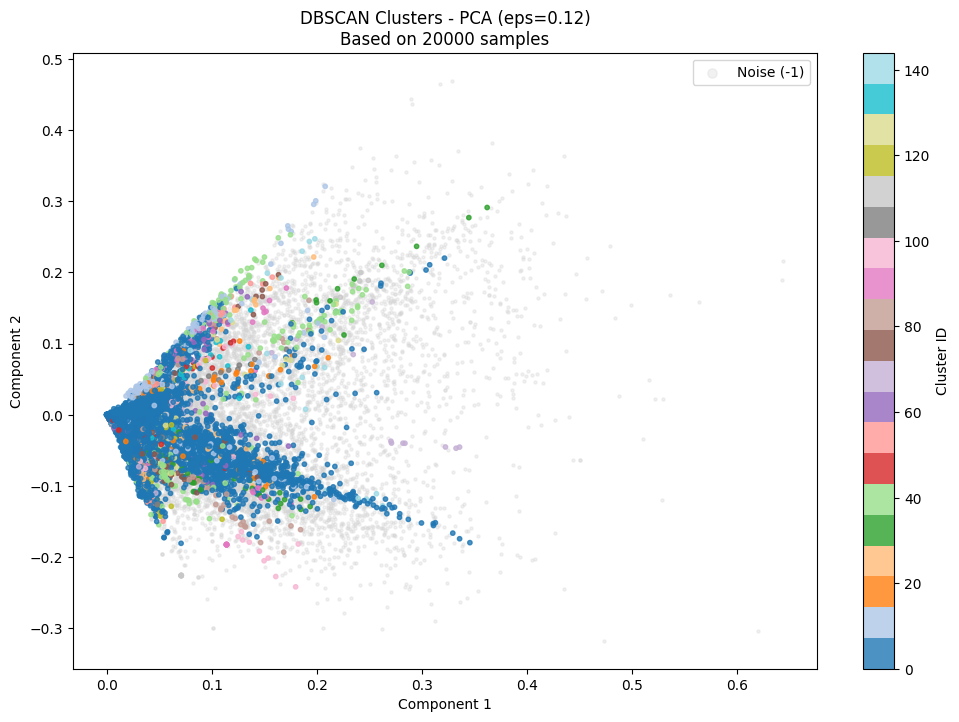


Subsampling to 5000 points for t-SNE (speed optimization)...
Running t-SNE...


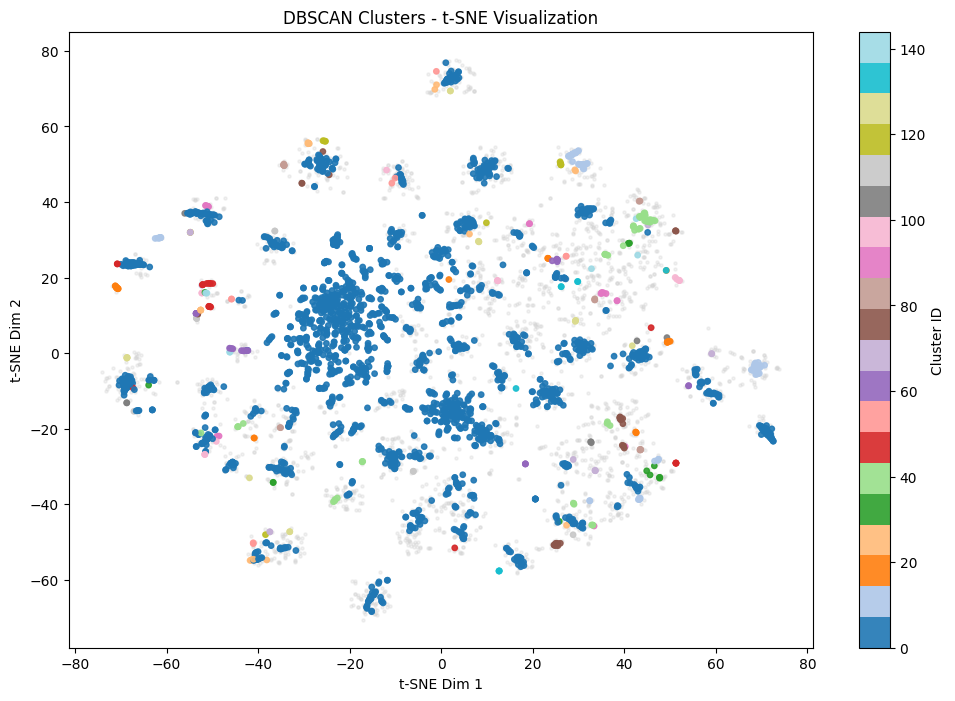

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np

# שימוש במשתנים שיצרת בתא הקודם
# מנגנון בטיחות: מוודא שהמשתנים קיימים
if 'X_subset' not in locals() or 'dbscan_labels' not in locals():
    raise ValueError("Missing variables! Please run the sampling & DBSCAN cell first.")

labels_to_plot = dbscan_labels
X_plot_data = X_subset

print(f"Visualizing {len(labels_to_plot)} points...")

# הכנת דאטה פריים לציור
plot_df = pd.DataFrame(X_plot_data[:, :2], columns=['x', 'y'])
plot_df['label'] = labels_to_plot

# --- Plot 1: PCA (2D) ---
plt.figure(figsize=(12, 8))

# ציור רעש (-1) באפור בהיר
noise_data = plot_df[plot_df['label'] == -1]
plt.scatter(noise_data['x'], noise_data['y'], c='lightgray', label='Noise (-1)', s=5, alpha=0.3)

# ציור האשכולות האמיתיים בצבע
cluster_data = plot_df[plot_df['label'] != -1]
scatter = plt.scatter(cluster_data['x'], cluster_data['y'], c=cluster_data['label'], cmap='tab20', s=10, alpha=0.8)

plt.title(f'DBSCAN Clusters - PCA (eps=0.12)\nBased on {len(plot_df)} samples')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
if not cluster_data.empty:
    plt.colorbar(scatter, label='Cluster ID')
plt.legend(markerscale=3)
plt.show()

# --- Plot 2: t-SNE ---
# דגימה נוספת רק אם המדגם עדיין גדול מדי ל-t-SNE (מעל 5000)
TSNE_LIMIT = 5000

if len(labels_to_plot) > TSNE_LIMIT:
    print(f"\nSubsampling to {TSNE_LIMIT} points for t-SNE (speed optimization)...")
    np.random.seed(42)
    indices_tsne = np.random.choice(len(labels_to_plot), TSNE_LIMIT, replace=False)
    X_tsne_input = X_plot_data[indices_tsne]
    labels_tsne = labels_to_plot[indices_tsne]
else:
    X_tsne_input = X_plot_data
    labels_tsne = labels_to_plot

print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne_2d = tsne.fit_transform(X_tsne_input)

# ציור t-SNE
plt.figure(figsize=(12, 8))
noise_mask = (labels_tsne == -1)
plt.scatter(X_tsne_2d[noise_mask, 0], X_tsne_2d[noise_mask, 1], c='lightgray', label='Noise (-1)', s=5, alpha=0.3)
scatter = plt.scatter(X_tsne_2d[~noise_mask, 0], X_tsne_2d[~noise_mask, 1], c=labels_tsne[~noise_mask], cmap='tab20', s=15, alpha=0.9)

plt.title('DBSCAN Clusters - t-SNE Visualization')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
if np.sum(~noise_mask) > 0:
    plt.colorbar(scatter, label='Cluster ID')
plt.show()

**Cell 10: Evaluation with Contingency Matrix**

In [24]:

from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score
import numpy as np
import pandas as pd

def purity_score(y_true, y_pred):
    """
    חישוב מדד Purity באמצעות contingency_matrix.
    מתאים גם כשהתוויות הן מסוגים שונים (מחרוזות מול מספרים).
    """
    # חישוב מטריצת המתאם (שורות=אמת, עמודות=אשכולות)
    c_matrix = contingency_matrix(y_true, y_pred)

    # לכל אשכול (עמודה), לוקחים את הערך המקסימלי (הסיווג הדומיננטי)
    # סוכמים את המקסימומים ומחלקים בסך כל הדוגמאות
    return np.sum(np.amax(c_matrix, axis=0)) / np.sum(c_matrix)

print("Evaluating Clustering Performance against Ground Truth ('level')...")

# 1. בדיקת קיום התוויות
if 'level' not in df_subset.columns:
    print("Error: 'level' column not found in df_subset!")
    print("Make sure your original dataset had a 'level' column and that df_subset preserved it.")
else:
    # 2. הכנת הנתונים
    y_true = df_subset['level']  # התוויות האמיתיות (easy, medium, hard)

    # בחירה אוטומטית של התוויות הזמינות
    if 'cluster_viz' in df_subset.columns:
        y_pred = df_subset['cluster_viz']
        print("Using labels from: 'cluster_viz'")
    elif 'dbscan_cluster_tuned' in df_subset.columns:
        y_pred = df_subset['dbscan_cluster_tuned']
        print("Using labels from: 'dbscan_cluster_tuned'")
    elif 'dbscan_cluster' in df_subset.columns:
        y_pred = df_subset['dbscan_cluster']
        print("Using labels from: 'dbscan_cluster'")
    else:
        raise ValueError("No clustering labels found in df_subset.")

    # 3. חישוב ARI
    ari = adjusted_rand_score(y_true, y_pred)
    print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")

    # 4. חישוב Purity (הגרסה המתוקנת)
    purity = purity_score(y_true, y_pred)
    print(f"Purity: {purity:.4f}")

    print("-" * 40)
    print("Interpretation:")
    if ari < 0.1:
        print("- Low ARI: The clusters (topics) do not match the difficulty labels (easy/medium/hard).")
        print("  This confirms that the content topic does not dictate the question difficulty.")
    else:
        print("- Moderate/High ARI: There is some correlation between topic and difficulty.")

Evaluating Clustering Performance against Ground Truth ('level')...
Using labels from: 'dbscan_cluster'

Adjusted Rand Index (ARI): -0.0126
Purity: 0.6292
----------------------------------------
Interpretation:
- Low ARI: The clusters (topics) do not match the difficulty labels (easy/medium/hard).
  This confirms that the content topic does not dictate the question difficulty.


# ***הסבר ניתוח התרגיל***
1. השורה התחתונה: אין שום קשר
התוצאה מאשרת באופן מתמטי שאין קשר בין האשכולות (הנושאים) לבין רמת הקושי. במילים פשוטות: אי אפשר להגיד על נושא מסוים שהוא "נושא קשה" או "נושא קל". כל נושא (Cluster) מכיל בתוכו ערבוב של שאלות קלות, בינוניות וקשות.

2. ניתוח המדדים
ARI: -0.0126 (שלילי/אפסי)
המשמעות: הציון הזה הוא למעשה 0. כשה-ARI קרוב לאפס (או שלילי מעט), זה אומר שהחפיפה בין האשכולות לבין רמות הקושי היא אקראית לחלוטין.

ההסבר: אם היית מטיל קובייה כדי לקבוע לאיזה אשכול שייכת כל שאלה, היית מקבל תוצאה דומה. האלגוריתם (DBSCAN) קיבץ את השאלות לפי דמיון בטקסט (נושאים), והעובדה שה-ARI נמוך מוכיחה שרמת הקושי "חותכת" את הנושאים לרוחב ולא תלויה בהם.

Purity: 0.6292 (כ-63%)
המשמעות: בכל אשכול, כ-63% מהשאלות הן מאותה רמת קושי (למשל, הרוב "בינוני").

הסתייגות חשובה: במבט ראשון זה נראה "לא רע", אבל בשילוב עם ה-ARI האפסי, הנתון הזה כנראה נובע מחוסר איזון בנתונים המקוריים.

דוגמה: אם 60% מכל השאלות שלך במאגר הן ברמה "Medium", אז גם אם תחלק את השאלות לקבוצות באופן אקראי לגמרי, עדיין תקבל Purity של סביב 0.6. לכן, הנתון הזה לא מעיד על הצלחה של האשכולות לחזות קושי, אלא משקף את ההתפלגות הכללית של הדאטה שלך.

3. המסקנה העסקית/מחקרית
התוצאה הזו היא טובה מאוד אם המטרה שלך הייתה להוכיח שרמת הקושי היא תכונה נפרדת מהנושא.

הוכחת ש"נושא" (Topic) הוא לא מנבא (Predictor) של "קושי" (Difficulty).

זה אומר שכשתבנה מודל לחיזוי רמת קושי, תצטרך להסתמך על מאפיינים אחרים (כמו אורך השאלה, מורכבות המילים, מבנה המשפט) ולא רק על "על מה השאלה מדברת".


# **חלק ב- חילוץ קשרים**

**Cell 11: Run TF-IDF and find the top 10 words**

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd


# אם אתה רוצה להריץ על כל הדאטה:
df_full = df_working.copy() # אם df_working מכיל את עמודת האשכולות
# אם האשכולות מוגדרים על המדגם, צריך לוודא שהם מיוחסים לדאטה המקורי.
# לצורך הקוד הזה, אני אניח ש-df_full הוא ה-DataFrame שעליו בוצע ה-DBSCAN.


# ----------------------------------------------------------------------
# 1. הגדרת ה-Vectorizer
# ----------------------------------------------------------------------
# השתמש באותם פרמטרים ששימשו ליצירת מטריצת ה-TF-IDF המקורית!
# (זה קריטי להשוואה עקבית)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
print("Vectorizer initialized.")


# ----------------------------------------------------------------------
# 2. זיהוי האשכולות וניתוח (על כל האשכולות)
# ----------------------------------------------------------------------

# זיהוי כל האשכולות הייחודיים, ללא הרעש (-1)
all_clusters = df_full['dbscan_cluster'].unique()
clusters_to_analyze = [c for c in all_clusters if c != -1]

print(f"\n--- TF-IDF Feature Extraction for ALL {len(clusters_to_analyze)} Clusters ---")

results_by_cluster = {} # נשמור את התוצאות במילון

# מעבר על כל אשכול (ללא הרעש)
for cluster_id in clusters_to_analyze:

    # סינון השאלות השייכות לאשכול הנוכחי
    cluster_questions = df_full[df_full['dbscan_cluster'] == cluster_id]['question']
    cluster_size = len(cluster_questions)

    if cluster_size < 2:
        print(f"Cluster {cluster_id} is too small ({cluster_size} items) for analysis. Skipping.")
        continue

    # 1. הפעלת TF-IDF על השאלות של האשכול בלבד
    # (fit_transform מבטיח שהציונים יהיו רלוונטיים רק למונחים באשכול זה)
    tfidf_matrix = vectorizer.fit_transform(cluster_questions)

    # 2. מיצוי שמות המאפיינים (המילים)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # 3. חישוב הציונים הממוצעים של המילים (Weighted by TF-IDF)
    tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)

    # 4. מיון ובחירת 10 המילים המובילות
    sorted_indices = tfidf_scores.argsort()[::-1]
    top_n = 10
    top_features = feature_names[sorted_indices[:top_n]]

    results_by_cluster[cluster_id] = {
        'size': cluster_size,
        'keywords': top_features.tolist()
    }

    # הדפסת התוצאות
    print(f"\nCluster {cluster_id} (Size: {cluster_size}) - TOP 10 TOPIC WORDS:")
    print(", ".join(top_features))

# ----------------------------------------------------------------------
# 3. טיפול והצגת הרעש (-1)
# ----------------------------------------------------------------------
noise_df = df_full[df_full['dbscan_cluster'] == -1]
n_noise = len(noise_df)

print(f"\n{'='*40}")
print(f"Cluster -1 (NOISE / OUTLIERS)")
print(f"{'='*40}")
print(f"Contains {n_noise} documents considered as noise.")

if n_noise > 0:
    print("\nSample Noise Questions (5 random samples):")
    sample = noise_df['question'].sample(min(5, n_noise), random_state=42).values
    for i, q in enumerate(sample):
        print(f"  {i+1}. {q}")

Vectorizer initialized.

--- TF-IDF Feature Extraction for ALL 100 Clusters ---

Cluster 58 (Size: 93) - TOP 10 TOPIC WORDS:
film, american, year, did, born, actor, type, nationality, known, series

Cluster 20 (Size: 98) - TOP 10 TOPIC WORDS:
film, year, american, did, born, city, director, played, directed, actress

Cluster 46 (Size: 89) - TOP 10 TOPIC WORDS:
american, did, starred, year, film, born, actress, written, city, known

Cluster 65 (Size: 77) - TOP 10 TOPIC WORDS:
american, film, nationality, located, airport, born, founded, city, song, year

Cluster 97 (Size: 82) - TOP 10 TOPIC WORDS:
film, year, american, city, country, located, born, song, formed, president

Cluster 34 (Size: 86) - TOP 10 TOPIC WORDS:
film, did, country, born, song, based, located, actress, series, american

Cluster 88 (Size: 95) - TOP 10 TOPIC WORDS:
film, american, born, year, did, award, played, nationality, directed, football

Cluster 45 (Size: 92) - TOP 10 TOPIC WORDS:
film, known, american, did, act

**Give a topic for each Cluster**

# **חלק ג- ניתוח בלשני, חילוץ קשרים**

In [37]:
import spacy
import pandas as pd
import numpy as np

# ----------------------------------------------------------------------
# הנחות וטעינה (וודא שבוצעו בשלבים הקודמים)
# ----------------------------------------------------------------------
# הנחה: df_working מכיל את עמודת 'question' ואת עמודת האשכולות 'dbscan_cluster'.
try:
    # טעינת SpaCy
    nlp = spacy.load("en_core_web_sm")
    print("SpaCy model loaded successfully.")
except:
    print("CRITICAL ERROR: SpaCy model not loaded.")
    raise

# האשכולות שבחרת לנתח לעומק (שלב 1)
CLUSTERS_TO_ANALYZE = [20, 58]
SAMPLE_SIZE = 25 # גודל המדגם הנדרש (20-30 שאלות)

# ----------------------------------------------------------------------
# 1. הגדרת פונקציות החילוץ הבסיסיות (כחלופה ל-Textacy)
# ----------------------------------------------------------------------

def extract_svo_basic(doc):
    # Subject-Verb-Object: מחפש נושא (nsubj), פועל ראשי (ROOT/VERB), ומושא (dobj/pobj)
    triples = []
    for token in doc:
        if token.dep_ == 'ROOT' or token.pos_ == 'VERB':
            subject = [child for child in token.children if child.dep_ == 'nsubj']
            obj = [child for child in token.children if child.dep_ == 'dobj' or child.dep_ == 'pobj']
            if subject and obj:
                triples.append({
                    'Entity 1': subject[0].text,
                    'Relation': token.text,
                    'Entity 2': obj[0].text,
                    'Type': 'SVO (Basic)'
                })
    return triples

def extract_entity_attribute(doc):
    # Entity-Attribute: מחפש ישות עם תואר (amod) או תיאור (attr)
    triples = []
    for token in doc:
        # קשר IS_A (attr) - למשל: "He is a doctor"
        if token.dep_ == 'attr' and token.head.dep_ == 'ROOT':
            subject = [child for child in token.head.children if child.dep_ == 'nsubj']
            if subject:
                 triples.append({
                     'Entity 1': subject[0].text,
                     'Relation': 'IS_A',
                     'Entity 2': token.text,
                     'Type': 'Entity-Attribute'
                })
        # קשר HAS_ATTRIBUTE (amod) - למשל: "red car"
        if token.dep_ == 'amod' and token.head.pos_ in ('NOUN', 'PROPN'):
             triples.append({
                 'Entity 1': token.head.text,
                 'Relation': 'HAS_ATTRIBUTE',
                 'Entity 2': token.text,
                 'Type': 'Entity-Attribute'
            })
    return triples

def extract_entity_location(doc):
    # Entity-Location: מחפש ישויות גיאוגרפיות (LOC/GPE)
    triples = []
    for ent in doc.ents:
        if ent.label_ in ('LOC', 'GPE', 'FAC'):
            head_token = ent.root.head
            relation = head_token.text if head_token.pos_ in ('VERB', 'ADP', 'AUX', 'ADP') else "ENTITY"
            triples.append({
                'Entity 1': relation,
                'Relation': 'LOCATED_IN',
                'Entity 2': ent.text,
                'Type': 'Entity-Location'
            })
    return triples


# ----------------------------------------------------------------------
# 2. הרצה על המדגם ושמירת התוצאות
# ----------------------------------------------------------------------
all_extracted_triples = []

print(f"\nRunning Basic Relation Extraction on Clusters: {CLUSTERS_TO_ANALYZE}")

for cluster_id in CLUSTERS_TO_ANALYZE:
    cluster_df = df_working[df_working['dbscan_cluster'] == cluster_id]

    if len(cluster_df) == 0:
        print(f"Cluster {cluster_id} is empty. Skipping.")
        continue

    # דגימה (שלב 1)
    sample_cluster_df = cluster_df.sample(min(SAMPLE_SIZE, len(cluster_df)), random_state=42)
    sample_cluster_df['doc'] = list(nlp.pipe(sample_cluster_df['question']))

    # חילוץ (שלב 2)
    for index, row in sample_cluster_df.iterrows():
        doc = row['doc']
        question = row['question']

        # הרצת שלושת הקשרים הבסיסיים
        triples = []
        triples.extend(extract_svo_basic(doc))
        triples.extend(extract_entity_attribute(doc))
        triples.extend(extract_entity_location(doc))

        # שמירת הטריפלטים עם מידע הקשר והשאלה
        for triple in triples:
             triple['Cluster'] = cluster_id
             triple['Question'] = question
             all_extracted_triples.append(triple)

# הפיכת רשימת הטריפלטים ל-DataFrame לניתוח נוח
df_basic_triples = pd.DataFrame(all_extracted_triples)

print(f"\n{'='*80}")
print("BASIC RELATION EXTRACTION COMPLETE (SVO, Attribute, Location)")
print(f"Total Triples Extracted: {len(df_basic_triples)}")
print(f"{'='*80}")

# --- הצגת הפלט לניתוח ---
for cluster_id in CLUSTERS_TO_ANALYZE:
    df_cluster_output = df_basic_triples[df_basic_triples['Cluster'] == cluster_id]

    print(f"\n--- Cluster {cluster_id} Triples (Top 10 Basic Relations) ---")
    if not df_cluster_output.empty:
        # הצגת טבלה של הקשרים הבסיסיים שחולצו
        print(df_cluster_output[['Entity 1', 'Relation', 'Entity 2', 'Type', 'Question']].head(10).to_markdown(index=False))
    else:
        print("No basic relations found in this cluster sample.")

SpaCy model loaded successfully.

Running Basic Relation Extraction on Clusters: [20, 58]

BASIC RELATION EXTRACTION COMPLETE (SVO, Attribute, Location)
Total Triples Extracted: 120

--- Cluster 20 Triples (Top 10 Basic Relations) ---
| Entity 1   | Relation      | Entity 2      | Type             | Question                                                                                                                                                                                                                     |
|:-----------|:--------------|:--------------|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| that       | had           | defenceman    | SVO (Basic)      | What was called the Erste Bank Eishockey Liga, that had a Canadian professional ice hockey defenceman drafted by the Minn